In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

## More dependencies
import scipy.fft as spfft
from scipy.ndimage import gaussian_filter1d as sp_gaussian_filter1d
from scipy.ndimage import affine_transform as sp_affine_transform
from scipy.ndimage import gaussian_filter as sp_gaussian_filter
from scipy.optimize import minimize
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

cupyon=True

try:
    import cupy as cp
    import numpy as np
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")


In [21]:
## Global Variables
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform

focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 3000
numpix_real = 4096*2
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 300*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = 400*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 600*10**(-6) # End location of the AOD in microns


polynomialbasis = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)
print(len(AWGwaveform))



Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  2.5
Fourier space spacing in microns:  0.279931640625
Fourier space aperture in microns:  2293.2
Timestep in nanoseconds: 3.8461538461538463
84000


In [13]:
testfrequency = 80e6
wavelength = soundvelocity / testfrequency
cycles = aodaperture / wavelength
cycles

923.0769230769231

In [ ]:
tweezerpower = 1 mW per tweezerpower

trapdepth 10 MHz

initialatomtemp = 0 ~ 1/2 MHz 

In [6]:


def initpath_linearramp(globalvariables):
    '''Initializes positions throughout the movementtime with an acceleration profile that is a linear ramp up for half the time then down for half the time that moves
    the atom from startlocation to endlocation.'''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    
    # Define the number of time steps
    num_steps = 1000
    total_time = movementtime
    time = np.linspace(0, total_time, num_steps)
    
    # Initial and final positions
    initial_position = startlocation * 10**6  # Convert to micrometers
    final_position = endlocation * 10**6  # Convert to micrometers
    D = final_position - initial_position
    
    # Calculate the constant acceleration needed
    a_max = (4 * D) / (total_time**2)  # Maximum acceleration
    
    # Initialize arrays for acceleration, velocity, position, and jerk
    accelerations = np.zeros(num_steps)
    velocities = np.zeros(num_steps)
    positions = np.zeros(num_steps)
    jerks = np.zeros(num_steps)
    
    # Calculate acceleration, velocity, and position for each time step
    half_time = total_time / 2
    half_steps = num_steps // 2
    time_step = total_time / num_steps
    
    for i in range(num_steps):
        if i <= half_steps:
            # Ramp up phase
            current_time = i * time_step
            accelerations[i] = a_max * (current_time / half_time)
        else:
            # Ramp down phase
            current_time = (i - half_steps) * time_step
            accelerations[i] = a_max * (1 - (current_time / half_time))

    def integrate_acceleration(acceleration, dt):
        velocity = np.cumsum(acceleration) * dt
        position = np.cumsum(velocity) * dt
        return velocity, position

    # Function to calculate jerk from acceleration
    def calculate_jerk(acceleration, dt):
        jerk = np.gradient(acceleration, dt)
        return jerk

    velocities, positions = integrate_acceleration(accelerations, time_step)
    jerks = calculate_jerk(accelerations, time_step)

    positions = positions / 10**6 + startlocation
    velocities = velocities / 10**6
    accelerations = accelerations / 10**6
    jerks = jerks / 10**6

    return positions,velocities,accelerations, jerks, time

def initpath_minimizejerk(globalvariables):
    '''Initializes positions throughout the movementtime that minimizes jerk.'''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    # Define the number of time steps and total time
    num_steps = 1000
    total_time = movementtime  # You may need to adjust this based on the problem's requirements
    time = np.linspace(0, 10, num_steps)
    time_out = np.linspace(0, total_time, num_steps)
    # Initial and final conditions
    initial_position = startlocation*(10**6)
    final_position = endlocation*(10**6)
    D = final_position - initial_position

    # Function to calculate velocity and position from acceleration
    def integrate_acceleration(acceleration, dt):
        velocity = np.cumsum(acceleration) * dt
        position = np.cumsum(velocity) * dt
        return velocity, position

    # Function to calculate jerk from acceleration
    def calculate_jerk(acceleration, dt):
        jerk = np.gradient(acceleration, dt)
        return jerk

    # Objective function to minimize jerk and achieve target position
    def objective(acceleration, dt):
        velocity, position = integrate_acceleration(acceleration, dt)
        jerk = calculate_jerk(acceleration, dt)
        jerk_cost = np.sum(jerk**2)  # Minimize the squared jerk
        position_error = (position[-1] - D)**2  # Ensure final position is D
        velocity_error = velocity[-1]**2  # Ensure final velocity is 0
        return jerk_cost + position_error + velocity_error

    # Initial guess for the acceleration profile
    initial_guess = np.zeros(num_steps)

    # Optimization constraints
    constraints = [
        {'type': 'eq', 'fun': lambda a: integrate_acceleration(a, time[1] - time[0])[1][-1] - D},  # Final position constraint
        {'type': 'eq', 'fun': lambda a: integrate_acceleration(a, time[1] - time[0])[0][-1]},     # Final velocity constraint
    ]

    # Perform the optimization
    result = minimize(objective, initial_guess, args=(time[1] - time[0]), constraints=constraints, method='SLSQP')

    # Extract the optimized acceleration profile
    optimized_acceleration = result.x
    optimized_velocity, optimized_position = integrate_acceleration(optimized_acceleration, time[1] - time[0])
    optimized_jerk = calculate_jerk(optimized_acceleration, time[1] - time[0])
    
    optimized_acceleration = optimized_acceleration / (10**6)
    optimized_velocity = optimized_velocity / (10**6)
    optimized_position = (optimized_position)/ (10**6) + startlocation
    optimized_jerk = optimized_jerk / (10**6)
    
    return optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time_out

def positionstofourier(positions, time, globalvariables):
    '''Converts positions from initialized paths onto pixels in the fourier plane, preserving accuracy by storing as floats. These will later be converted to desired
    spots on the AWG waveform.'''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables
    framecenter = numpix_real / 2
    fourierpixels = (positions / pixelsize_fourier) + framecenter

    return fourierpixels, time

def expand_position_array(time, position, globalvariables):
    '''
    Expands the position array to match the resolution of the AWGwaveform time array.
    
    Parameters:
        time (np.array): The array of time values corresponding to the position array.
        position (np.array): The array of position values.
        AWGwaveform (np.array): The higher resolution time array for the AWG waveform.
        
    Returns:
        np.array: The expanded position array.
    '''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    AWGtime = np.linspace(0,movementtime, int(movementtime / cycletime * numpix_frame))
    # Create an interpolation function based on the original time and position arrays
    interpolation_function = interp1d(tonumpy(time), tonumpy(position), kind='linear', fill_value='extrapolate')
    
    # Use the interpolation function to generate the expanded position array
    expanded_position = interpolation_function(tonumpy(AWGtime))
    
    return expanded_position, AWGtime

def realtofourier(inputarray):
    """
    Simulate the Fourier transform of a waveform.
    
    Parameters:
    inputarray (cp.ndarray): The input waveform.
    
    Returns:
    cp.ndarray: The Fourier transform of the input waveform.
    """
    # Perform the Fourier transform
    outputarray = cpfft.fftshift(cpfft.fft(cpfft.fftshift(inputarray), norm="ortho"))
    fourierintensity = cp.square (cp.abs(outputarray))
    return fourierintensity

def fouriertoreal(inputarray):
    """
    Simulate the Fourier transform of a waveform.
    
    Parameters:
    inputarray (cp.ndarray): The input waveform.
    
    Returns:
    cp.ndarray: The Fourier transform of the input waveform.
    """
    # Perform the Fourier transform
    outputarray = cpfft.ifftshift(cpfft.fft(cpfft.ifftshift(inputarray), norm="ortho"))
    fourierintensity = cp.square (cp.abs(outputarray))
    return fourierintensity

def initguess_continuouscosine(AWGwaveform, positions, time, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    AWG_fourierspace = cp.zeros(len(AWGwaveform))
    fourierpixels, time = positionstofourier(positions, time, globalvariables)
    expanded_fourierpixels, expanded_time = expand_position_array(time, fourierpixels, globalvariables)
    AWG_fourierspace[numpix_frame: -numpix_frame] = tocupy(expanded_fourierpixels)
    frequency_t0 = fourierpixels[0]
    frequency_tF = fourierpixels[-1]
    print(frequency_t0)
    print(frequency_tF)
    AWG_fourierspace[0:numpix_frame] = frequency_t0
    AWG_fourierspace[-numpix_frame:] = frequency_tF
    AWG_time = cp.linspace(0, 1*len(AWGwaveform) / numpix_real, len(AWGwaveform))
    
    AWG_fourierspace = AWG_fourierspace - numpix_real // 2

    AWGwaveform_out = cp.cos(2*cp.pi*cp.cumsum(AWG_fourierspace) * (AWG_time[1] - AWG_time[0]))
    

    return AWGwaveform_out

def snapshot(cycle, globalvariables):
    '''Cycle here is non-zero padded section of length numpix_frame of the AWGwaveform.'''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    cycle = zeropadframe(cycle, globalvariables)
    return realtofourier(cycle)

def retrieveforces(AWGwaveform, globalvariables, timeperframe = 1):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    num_snapshots = (len(AWGwaveform) - numpix_frame) // timeperframe + 1
    
    # Create a view of the input array with overlapping windows
    strides = (AWGwaveform.strides[0] * timeperframe, AWGwaveform.strides[0])
    shape = (num_snapshots, numpix_frame)
    snapshots = as_strided(AWGwaveform, shape=shape, strides=strides)    
    snapshots = cp.array([realtofourier(zeropadframe(snap, globalvariables)) for snap in snapshots])

    snapshots = calculateforces(snapshots)

    if timeperframe > 1:
        interpolated_snapshots = cp.zeros((num_snapshots + (num_snapshots - 1) * (timeperframe - 1), numpix_real), dtype=AWGwaveform.dtype)
        interpolated_snapshots[::timeperframe] = snapshots
        
        for i in range(1, timeperframe):
            interpolated_snapshots[i::timeperframe] = (snapshots[:-1] * (timeperframe - i) + snapshots[1:] * i) / timeperframe
        
        return interpolated_snapshots

    return snapshots

def retrievepotentials(AWGwaveform, globalvariables, timeperframe = 1):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    num_snapshots = (len(AWGwaveform) - numpix_frame) // timeperframe + 1
    
    # Create a view of the input array with overlapping windows
    strides = (AWGwaveform.strides[0] * timeperframe, AWGwaveform.strides[0])
    shape = (num_snapshots, numpix_frame)
    snapshots = as_strided(AWGwaveform, shape=shape, strides=strides)    
    snapshots = cp.array([realtofourier(zeropadframe(snap, globalvariables)) for snap in snapshots])


    if timeperframe > 1:
        interpolated_snapshots = cp.zeros((num_snapshots + (num_snapshots - 1) * (timeperframe - 1), numpix_real), dtype=AWGwaveform.dtype)
        interpolated_snapshots[::timeperframe] = snapshots
        
        for i in range(1, timeperframe):
            interpolated_snapshots[i::timeperframe] = (snapshots[:-1] * (timeperframe - i) + snapshots[1:] * i) / timeperframe
        
        return interpolated_snapshots

    return snapshots

def calculateforces(potentials):
    forces = cp.zeros_like(potentials)
    forces = [gradient(potential) * potential for potential in potentials]
    return cp.array(forces)


# quality of life
def gradient(arr):
    # Calculate the spacing between points
    dx = 1.0  # Assuming unit spacing for simplicity; adjust if needed
    
    # Compute the first derivative using central differences
    derivative = (cp.roll(arr, -1) - cp.roll(arr, 1)) / (2 * dx)
    
    # Handle boundaries with forward and backward differences
    derivative[0] = (arr[1] - arr[0]) / dx
    derivative[-1] = (arr[-1] - arr[-2]) / dx
    
    return cp.array(derivative)


def tonumpy(array):
    '''Checks if the input array is a CuPy array and converts it to a NumPy array if necessary.'''
    if isinstance(array, cp.ndarray):
        return cp.asnumpy(array)  # Convert CuPy array to NumPy array
    elif isinstance(array, np.ndarray):
        return array  # Already a NumPy array, return as is
    else:
        raise TypeError("Input is neither a NumPy nor a CuPy array")

def tocupy(array):
    '''Checks if the input array is a NumPy array and converts it to a CuPy array if necessary.'''
    if isinstance(array, np.ndarray):
        return cp.asarray(array)  # Convert NumPy array to CuPy array
    elif isinstance(array, cp.ndarray):
        return array  # Already a CuPy array, return as is
    else:
        raise TypeError("Input is neither a NumPy nor a CuPy array")

def zeropadframe(frame, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    paddedframe = cp.zeros(numpix_real)
    paddedframe[(numpix_real - numpix_frame) // 2: (numpix_real + numpix_frame) // 2] = frame
    return paddedframe


In [22]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_linearramp(globalvariables)
# optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_minimizejerk(globalvariables)
fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)
expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)

AWGinitguesscosine = initguess_continuouscosine(AWGwaveform, optimized_position, time, globalvariables)



6239.380429094715
6953.840572126286


In [5]:
potentials = retrievepotentials(AWGinitguesscosine, globalvariables, 10)

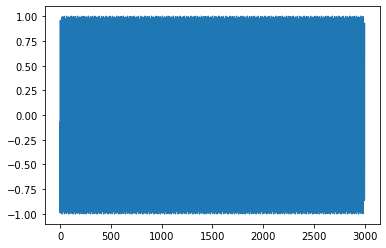

In [23]:
plt.plot(AWGinitguesscosine[0:3000].get())
def count_periods(cos_wave):
    # Convert numpy array to cupy array
    cos_wave_cp = cp.asarray(cos_wave)
    
    # Calculate autocorrelation
    autocorr = cp.correlate(cos_wave_cp, cos_wave_cp, mode='full')
    
    # Find peaks in autocorrelation (excluding the first peak which is the signal itself)
    peaks = cp.where(cp.diff(cp.sign(cp.diff(autocorr))) == -2)[0] + 1
    
    # Calculate period as the distance between consecutive peaks
    if len(peaks) > 1:
        periods = cp.diff(peaks)
        num_periods = len(periods)
    else:
        num_periods = 0
    
    return num_periods
num_periods = count_periods(AWGinitguesscosine[0:3000])


In [24]:
num_periods

1568

In [367]:
plt.figure(figsize=(12, 6))
plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[0:1000],globalvariables)).get())
plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[-1000:],globalvariables)).get())

plt.axvline(x=321+ numpix_real //2, color='red', linestyle='--')
plt.axvline(x=1393.1972789115648+ numpix_real //2, color='red', linestyle='--')



ValueError: operands could not be broadcast together with shapes (1000,), (2000,)

<Figure size 864x432 with 0 Axes>

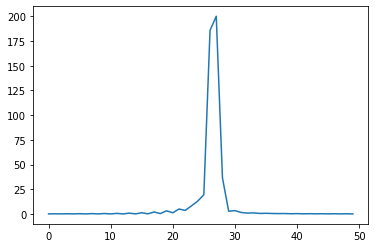

In [378]:
plt.plot(potentials[-400][2450:2500].get())




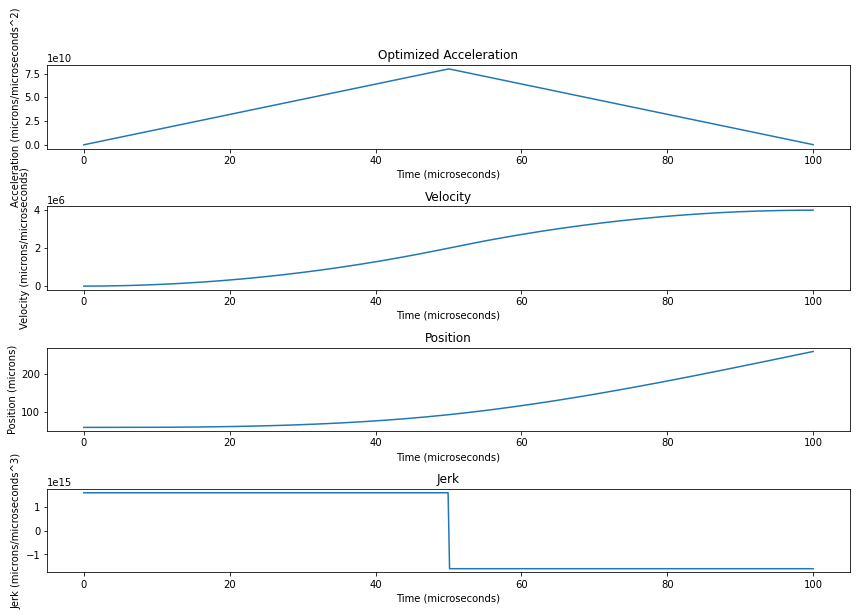

In [56]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time * 10**6, optimized_acceleration * 10**6)
plt.title('Optimized Acceleration')
plt.xlabel('Time (microseconds)')
plt.ylabel('Acceleration (microns/microseconds^2)')

plt.subplot(4, 1, 2)
plt.plot(time* 10**6, optimized_velocity* 10**6)
plt.title('Velocity')
plt.xlabel('Time (microseconds)')
plt.ylabel('Velocity (microns/microseconds)')

plt.subplot(4, 1, 3)
plt.plot(time* 10**6, optimized_position* 10**6)
plt.title('Position')
plt.xlabel('Time (microseconds)')
plt.ylabel('Position (microns)')

plt.subplot(4, 1, 4)
plt.plot(time* 10**6, optimized_jerk* 10**6)
plt.title('Jerk')
plt.xlabel('Time (microseconds)')
plt.ylabel('Jerk (microns/microseconds^3)')

plt.tight_layout()
plt.show()